In [1]:
import math
import json
import random
import ast
import re
from os import path
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation, CompoundLocation
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align import AlignInfo
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from scipy import stats
from collections import Counter

In [2]:
#given a polymorphism frequency, return bin
def frequency_binning(x, midfreq_high, midfreq_low):

    #nan frequencies are when there is no sequence coverage at the given position
    if math.isnan(x):
        f_bin = float('nan')
    else:
        if x == 1.0:
            f_bin = 'f'
        elif x>=midfreq_high:
            f_bin = 'h'
        elif x<midfreq_high and x>=midfreq_low:
            f_bin = 'm'
        elif x<midfreq_low:
            f_bin='l'

    return f_bin

In [3]:
outgroup_seq_test = Seq('ATGAAACCCGGGTTTAAACCCGGG')
outgroup_seq_aa_test = outgroup_seq_test.translate()
alignment_seqs_test = [Seq('ATGAAGCCCGGGATTAAACCCGGG'),
                  Seq('ATGAAGCCCGGGATTAAACCCGGG'),
                  Seq('ATGAAGCCCGGGATTAAACCCGCG'),
                  Seq('ATGAAGCCCGGGATTAAACCCGCG'),
                  Seq('ATGAAGCCCGGGATTAAACCCGCG'), 
                  Seq('ATGAAGCCCGGGATTAAACCCGCG'), 
                  Seq('ATGAAGCCCGGGATTAAACCCGAG'), 
                  Seq('ATGAAGCCCGGGTTTAAACCCGAG'), 
                  Seq('ATGAAGCCCGGGTTTAAACCCGTA'), 
                  Seq('ATGAAACCCGGGTTTAAACCCGTA')]

# walk_through_sites(outgroup_seq_test, outgroup_seq_aa_test, alignment_seqs_test, 0.75, 0.15)

In [4]:
def walk_through_sites(outgroup_seq, outgroup_aa_seq, alignment_seqs, midfreq_high, midfreq_low):

    #at each site, count number of viruses with polymorphism
    count_polymorphic = np.zeros(len(outgroup_seq))
    #at each site, count totaly number of viruses
    count_total_unambiguous = np.zeros(len(outgroup_seq))
    
    count_replacement_mutations = np.zeros(len(outgroup_seq))
    count_silent_mutations = np.zeros(len(outgroup_seq))
    
    #at each site, list of nucleotide from each virus
    ingroup_bases = [[] for x in range(len(outgroup_seq))]
    
    for seq in alignment_seqs:
        if len(seq) != len(outgroup_seq):
            print(len(seq), len(outgroup_seq))
            print(seq)
        elif len(seq) == len(outgroup_seq):                   
            for pos in range(len(outgroup_seq)):
                outgroup_nt = str(outgroup_seq[pos])
                virus_nt = str(seq[pos])

                #skip ambiguous sites
#                 if virus_nt != 'N' and virus_nt != 'W':
#                     if outgroup_nt != 'N' and outgroup_nt != 'W':
                if virus_nt in ['A', 'C', 'G', 'T']:
                    if outgroup_nt in ['A', 'C', 'G', 'T']:
                        ingroup_bases[pos].append(virus_nt)
                        count_total_unambiguous[pos]+=1
                        if virus_nt != outgroup_nt:
                            count_polymorphic[pos]+=1
                            #determine silent or replacement
                            codon = math.floor(pos/3)
                            
                            #some references include stop codon, some don't
                            if codon < len(outgroup_aa_seq):
                            
                                codon_pos = pos-(codon*3)
                                if codon_pos == 0:
                                    codon_nt = virus_nt+outgroup_seq[pos+1:(pos+3)]
                                elif codon_pos == 1:
                                    codon_nt = outgroup_seq[pos-1]+virus_nt+outgroup_seq[pos+1]
                                elif codon_pos == 2:
                                    codon_nt = outgroup_seq[(pos-2):(pos)]+virus_nt


                                if isinstance(codon_nt, str):
                                    codon_nt = Seq(codon_nt)

                                codon_aa = codon_nt.translate()
                                outgroup_aa = outgroup_aa_seq[codon]

                                if outgroup_aa != 'X':
                                    if codon_aa != outgroup_aa:
                                        count_replacement_mutations[pos]+=1
                                    elif codon_aa == outgroup_aa:
                                        count_silent_mutations[pos]+=1
                                        
    #don't give runtime error for 0/0 if no unambiguous bases at position
    #will insert 'nan' at appropriate position, which will be ignored at later step
    np.seterr(invalid='ignore')
    
    polymorphic_frequencies = count_polymorphic/count_total_unambiguous
    
    replacement_score = count_replacement_mutations/count_total_unambiguous
    
    freq_bins = [frequency_binning(x, midfreq_high, midfreq_low) for x in polymorphic_frequencies]
    
    return freq_bins, replacement_score, ingroup_bases

In [5]:
def determine_site_type(outgroup, ingroup):

    ingroup_bases_nan = set(ingroup)
    #remove 'nan's
    ingroup_bases = {x for x in ingroup_bases_nan if pd.notna(x)}

    
    if len(ingroup_bases) == 0:
        site_type = None
    
    elif len(ingroup_bases) != 0:
        #all ingroup bases are identical
        if len(ingroup_bases) == 1:
            if outgroup in ingroup_bases:
                site_type = 1
            elif outgroup not in ingroup_bases:
                site_type = 2

        #2 different bases in ingroup
        elif len(ingroup_bases) == 2:
            if outgroup in ingroup_bases:
                site_type = 3
            elif outgroup not in ingroup_bases:
                site_type = 4

        #3 different bases in ingroup
        elif len(ingroup_bases) == 3:
            if outgroup in ingroup_bases:
                site_type = 5
            elif outgroup not in ingroup_bases:
                site_type = 6

        #4 different bases in ingroup
        elif len(ingroup_bases) == 4:
            site_type = 7
    
    
    return site_type

In [6]:
def fixation_polymorphism_score(outgroup, ingroup):
    site_type = determine_site_type(outgroup, ingroup)

    
    if site_type == None:
        Fi = float('nan')
        Pi = float('nan')
    if site_type == 1:
        Fi = 0
        Pi = 0
    elif site_type == 2:
        Fi = 1
        Pi = 0
    elif site_type in [3,5,7]:
        Fi = 0
        Pi = 1
    elif site_type == 4:
        Fi = 0.5
        Pi = 0.5
    elif site_type == 6:
        Fi = (1/3)
        Pi = (2/3)
    
    return Fi, Pi

In [7]:
def assign_fi_pi(outgroup_seq, ingroup_bases):
    
    #at each site, record Fi
    Fi_all = np.zeros(len(outgroup_seq))
    
    #at each site, record Pi
    Pi_all = np.zeros(len(outgroup_seq))
    
    for pos in range(len(outgroup_seq)):
        outgroup_nt = outgroup_seq[pos]
        ingroup_nts = ingroup_bases[pos]
        Fi, Pi = fixation_polymorphism_score(outgroup_nt, ingroup_nts)
        Fi_all[pos] = Fi
        Pi_all[pos] = Pi
        
    return Fi_all, Pi_all
    
    
                            

In [8]:
def readin_virus_config(virus):
    config_json = f'config/adaptive_evo_config_{virus}.json'
    with open(config_json) as json_handle:
        configs = json.load(json_handle)
        
    return configs

In [79]:
def subset_viruses_nextstrain_build(virus, subtype, gene, window, min_seqs, year_max, year_min):

    
    
    configs = readin_virus_config(virus)
    standard_gene = standardize_gene_name(virus, gene)
    
    #some dengue files are shared between all genotypes of the same serotype
    if virus=='dengue':
        serotype = subtype.split('_')[0]
    else:
        serotype = False
    

    #Find reference, alignment and meta files (some sub-genic regions may use files from a gene or a whole genome)
    if 'specify_location' in configs[standard_gene].keys():
        parent_gene = configs[standard_gene]['specify_location']['parent_gene']
        alignment_file = configs['alignment_file'].format(virus=virus, subtype=subtype, gene=parent_gene)
        meta_file = configs['meta_file'].format(virus=virus, subtype=subtype, gene=parent_gene)
        #some are comma-separated, some are tab-separated
        metafile_sep = configs['metafile_sep']
    else:
        alignment_file = configs['alignment_file'].format(virus=virus, subtype=subtype, gene=gene)
        meta_file = configs['meta_file'].format(virus=virus, subtype=subtype, gene=gene)
        metafile_sep = configs['metafile_sep']
        #dengue reference files are shared among serotypes
        if serotype:
            reference_file = configs['reference_file'].format(virus=virus, subtype=serotype, gene=gene)
        else:
            reference_file = configs['reference_file'].format(virus=virus, subtype=subtype, gene=gene)
    
    # if a minimum year to use is supplied in config, limit seqs to this
    if 'min_year' in configs.keys():
        year_min = int(configs['min_year'])
    
    #Find gene location, if domain is sub-genic or reference file contains multiple genes
    gene_location = False
    #If domain is sub-genic, fetch its position (within genome or parent gene) from config file
    if 'specify_location' in configs[standard_gene].keys():
        if subtype==None:
            gene_location_key = "location"
        else:
            #dengue reference files and locations are shared among serotypes
            if serotype:
                gene_location_key = "location_"+str(serotype)
            else:
                gene_location_key = "location_"+str(subtype)
            
        gene_location_list = ast.literal_eval(configs[standard_gene]['specify_location'][gene_location_key])
        #Need to deal with domains the are not contiguous
        if len(gene_location_list)==1:
            gene_location = SeqFeature(FeatureLocation(gene_location_list[0][0], gene_location_list[0][1]))
        else:
            compound_locations = []
            for location in gene_location_list:
                compound_locations.append(FeatureLocation(location[0], location[1]))
            gene_location = CompoundLocation(compound_locations)
            

    #Find gene location from reference files
    else:
        for seq_record in SeqIO.parse(reference_file, "genbank"):
            for feature in seq_record.features:
                if feature.type == 'CDS':
                    if 'gene' in feature.qualifiers.keys():
                        if feature.qualifiers['gene'][0].lower() == gene.lower():
                            gene_location = feature.location
                    if gene_location==False:
                        if 'product' in feature.qualifiers.keys():
                            if feature.qualifiers['product'][0].lower() == gene.lower():
                                gene_location = feature.location 
                    if gene_location == False:
                        if 'locus_tag' in feature.qualifiers.keys():
                            if feature.qualifiers['locus_tag'][0].lower() == gene.lower():
                                gene_location = feature.location  
                    
                        
    #Subset data based on time windows
    meta = pd.read_csv(meta_file, sep = metafile_sep)
    #drop incomplete date data
    meta.drop(meta[meta['date']=='?'].index, inplace=True)
    meta = meta[meta["date"].str.contains("20XX")==False]
    meta = meta[meta["date"].str.contains("36-0")==False]
    meta.dropna(subset=['date'], inplace=True)
    meta['year'] = meta['date'].str[:4].astype('int')
    if year_max:
        meta.drop(meta[meta['year']>year_max].index, inplace=True)
    if year_min:
        meta.drop(meta[meta['year']<year_min].index, inplace=True)
    
    date_range = meta['year'].max() - meta['year'].min()
    #Remove egg- and cell-passaged strains
    meta.drop(meta[meta['strain'].str[-4:]=='-egg'].index, inplace=True)
    meta.drop(meta[meta['strain'].str[-5:]=='-cell'].index, inplace=True)
    
    #Limit meta data to only strains in alignment file
    aligned_isolates = []
    with open(alignment_file, "r") as aligned_handle:
        for isolate in SeqIO.parse(aligned_handle, "fasta"):
            aligned_isolates.append(isolate.id)
    aligned_isolates_df = pd.DataFrame(aligned_isolates, columns=['strain'])
    meta = meta.merge(aligned_isolates_df, on='strain', how='inner')
    
    
    #Group viruses by time windows
    virus_time_subset = {}
    if window == 'all':
        years = str(meta['year'].min()) + '-' + str(meta['year'].max())
        virus_time_subset[years] = meta['strain'].tolist()
    else:
        date_window_start = meta['year'].min()
        date_window_end = meta['year'].min() + window
        while date_window_end <= meta['year'].max():
            years = str(date_window_start) + '-' + str(date_window_end)
            strains = meta[(meta['year']>=date_window_start) & (meta['year']<date_window_end)]['strain'].tolist()
            virus_time_subset[years] = strains
            
            
            #sliding window
            date_window_end += 1
            date_window_start += 1 
    

    #Only use time points with enough data:
    virus_time_subset = {k:v for k,v in virus_time_subset.items() if len(v)>=min_seqs}
    
    year_windows = []
    seqs_in_window = []
    
    #Find outgroup sequence from strains at first time point(to make consensus from)
    first_window = True
    first_window_strains = []
    first_window_sequences = []
    
    alignment_time_subset = {}

    
    for years, subset_viruses in virus_time_subset.items():

        year_windows.append(years)
        seqs_in_window.append(len(subset_viruses))
        alignment_time_subset[years] = []

        #make consensus sequence at first time point
        if first_window == True:
            first_window_strains+=subset_viruses
            first_window = False
        

        with open(alignment_file, "r") as aligned_handle:
            for isolate in SeqIO.parse(aligned_handle, "fasta"):
                if isolate.id in first_window_strains:
                    if gene_location:
                        gene_record = SeqRecord(seq = gene_location.extract(isolate.seq), 
                                                id = isolate.id, description = gene)
                    else:
                        gene_record = SeqRecord(seq = isolate.seq, 
                                                id = isolate.id, description = gene)
                    first_window_sequences.append(gene_record)
                if isolate.id in subset_viruses:
                    if gene_location:
                        alignment_time_subset[years].append(gene_location.extract(isolate.seq))
                    else:
                        alignment_time_subset[years].append(isolate.seq)

    first_window_alignment = MultipleSeqAlignment(first_window_sequences)
    if virus=='rsv':
        outgroup_seq = AlignInfo.SummaryInfo(first_window_alignment).gap_consensus(ambiguous ='N')
    else:
        outgroup_seq = AlignInfo.SummaryInfo(first_window_alignment).dumb_consensus(ambiguous ='N')
    
    has_dup = find_duplication(outgroup_seq)
    
    #if virus has duplication, want to run Bhatt on entire alignment excluding dup, 
    #and then separately on the duplicated sequence to look at evolution occurring on top of it
    
    if has_dup:
        outgroup_seq, outgroup_seq_aa, alignment_time_subset = adjust_for_duplications(outgroup_seq, alignment_time_subset)
    else:
        outgroup_seq_aa = outgroup_seq.translate()

        
    return virus_time_subset, alignment_time_subset, outgroup_seq, outgroup_seq_aa, year_windows, seqs_in_window 
    

In [10]:
def find_duplication(outgroup_seq):
    """
    Duplication events (or any insertions) will be signified in the outgroup sequence 
    by a series of consecutive --- placeholders. Find if there is a duplication in this 
    evolution of this virus.
    """
    has_dup = False
    outgroup_seq_str = str(outgroup_seq)
    #if there are ---s in the outgroup_seq, find where they are
    #say that insertion/duplication has to be at least 3 codons long
    if re.search("-{9,}", outgroup_seq_str):
        has_dup=True
        
        
    return has_dup

In [11]:
def adjust_for_duplications(outgroup_seq, alignment_time_subset):
    """
    Find the position and length of the duplication.
    Remove the duplicated region from the outgroup sequence and the every sequence in the alignment.
    Evolution on the duplicated region will be considered separately because the outgroup consensus 
    for this region needs to done from the first timepoint where there are sequences with the duplication
    """

    outgroup_seq_str = str(outgroup_seq)
    #find where the duplication is by locating ---s in the outgroup_seq
    if re.search("-{9,}", outgroup_seq_str):
        dup_start, dup_end = [(x.start(),x.end()) for x in re.finditer(r'-{9,}', outgroup_seq_str)][0]


    outgroup_wo_dup = Seq(outgroup_seq_str[:dup_start]+outgroup_seq_str[dup_end:])
    outgroup_wo_dup_aa = outgroup_wo_dup.translate()

    # remove the duplicated portion from the main alignment
    alignment_time_subset_wo_dup = {}
    for dates, strain_seqs in alignment_time_subset.items():
        strain_seqs_wo_dup = [Seq(str(x)[:dup_start]+str(x)[dup_end:]) for x in strain_seqs]
        alignment_time_subset_wo_dup[dates] = strain_seqs_wo_dup
    
        
    
    return outgroup_wo_dup, outgroup_wo_dup_aa, alignment_time_subset_wo_dup



In [12]:
#for each time point, create sample alignment of same size as emperical alignment
def bootstrap_alignment(bootstrap_codon_order, sequences):
    
    bootstrap_alignment_seqs = []
    for virus_seq in sequences:
        virus_seq_str = str(virus_seq)
        virus_codons = [virus_seq_str[i:i+3] for i in range(0, len(virus_seq_str), 3)] 
        bootstrap_virus = ''.join([virus_codons[x] for x in bootstrap_codon_order])
        bootstrap_alignment_seqs.append(bootstrap_virus)
    
    return bootstrap_alignment_seqs

In [13]:
#sample codons from emperical ancestral sequence with replacement
def bootstrap_ancestral(outgroup_seq):
    outgroup_seq_str = str(outgroup_seq)
    #sample codons with replacement
    ancestral_codons = [outgroup_seq_str[i:i+3] for i in range(0, len(outgroup_seq_str), 3)] 
    bootstrap_codon_order = random.choices(range(len(ancestral_codons)), k=len(ancestral_codons))
    bootstrap_ancestral_seq = ''.join([ancestral_codons[x] for x in bootstrap_codon_order])
    bootstrap_ancestral_seq = Seq(bootstrap_ancestral_seq)
    return bootstrap_ancestral_seq, bootstrap_codon_order


In [14]:
def make_bootstrap_dataset(outgroup_seq, alignment_time_subset):
            
    bootstrap_ancestral_seq, bootstrap_codon_order = bootstrap_ancestral(outgroup_seq)
    bootstrap_ancestral_seq_aa = bootstrap_ancestral_seq.translate()
    
    bootstrap_alignment_seqs = {}
    for years, sequences in alignment_time_subset.items():
        bootstrap_sequences = bootstrap_alignment(bootstrap_codon_order, sequences)
        bootstrap_alignment_seqs[years] = bootstrap_sequences

        
    return bootstrap_ancestral_seq, bootstrap_ancestral_seq_aa, bootstrap_alignment_seqs

In [15]:
def calc_site_stats(alignment_sequences, outgroup_seq, outgroup_aa_seq, midfreq_high, midfreq_low):
    
    #Find percent polymorphism at each site
    #Also determine whether polymorphism is silent or replacement  
    

    #initiate lists to record all time windows
    frequency_bins = []
    fixation_scores = []
    polymorphism_scores = []
    replacement_scores = []
    silent_scores = []    
        

    for years, alignment_seqs in alignment_sequences.items():
  
        #calculate stats for each window separately
        freq_bins, replacement_score, ingroup_bases = walk_through_sites(outgroup_seq, outgroup_aa_seq, 
                                                                         alignment_seqs,
                                                                         midfreq_high, midfreq_low)
        Fi_all, Pi_all = assign_fi_pi(outgroup_seq, ingroup_bases)
        silent_score = 1-replacement_score

        frequency_bins.append(freq_bins)
        fixation_scores.append(Fi_all)
        polymorphism_scores.append(Pi_all)
        replacement_scores.append(replacement_score)
        silent_scores.append(silent_score)
            
            
            
    return frequency_bins, fixation_scores, polymorphism_scores, replacement_scores, silent_scores
            
            


In [16]:
#M=rm/sm 
#not expected to vary through time provided that long-term effective population sizes remain sufficiently large
#For each gene, calculate M by combining site count among time points

def calc_m_ratio(virus, subtype, gene, window, min_seqs, midfreq_high, midfreq_low, bootstrap, year_max, year_min):

    configs = readin_virus_config(virus)
    nonantigenic_gene = configs['nonantigenic_gene']

    
    if standardize_gene_name(virus, gene) =='ha_protein' or standardize_gene_name(virus, gene) =='receptor_binding':
        (virus_time_subset, alignment_time_subset, 
         outgroup_seq, outgroup_aa_seq, 
         year_windows, seqs_in_window) = subset_viruses_nextstrain_build(virus, subtype, nonantigenic_gene, 'all', 
                                                        min_seqs, year_max, year_min)
        if bootstrap:
            (bootstrap_ancestral_seq, bootstrap_ancestral_seq_aa,
             bootstrap_alignment_seqs) = make_bootstrap_dataset(outgroup_seq, alignment_time_subset)
        
        
    else:
        (virus_time_subset, alignment_time_subset, 
         outgroup_seq, outgroup_aa_seq, 
         year_windows, seqs_in_window) = subset_viruses_nextstrain_build(virus, subtype, gene, 'all', 
                                                        min_seqs, year_max, year_min)
        if bootstrap:
            (bootstrap_ancestral_seq, bootstrap_ancestral_seq_aa,
             bootstrap_alignment_seqs) = make_bootstrap_dataset(outgroup_seq, alignment_time_subset)
    
    if bootstrap:
            (frequency_bins, 
             fixation_scores, polymorphism_scores, 
             replacement_scores, silent_scores) = calc_site_stats(bootstrap_alignment_seqs, 
                                                                  bootstrap_ancestral_seq, bootstrap_ancestral_seq_aa, 
                                                                  midfreq_high, midfreq_low)
    else:
        (frequency_bins, 
         fixation_scores, polymorphism_scores, 
         replacement_scores, silent_scores) = calc_site_stats(alignment_time_subset, 
                                                              outgroup_seq, outgroup_aa_seq, midfreq_high, midfreq_low)
        
    
    sm = 0
    rm = 0
    
    for site in range(len(frequency_bins[0])):
        freq_bin = frequency_bins[0][site]
        if freq_bin == 'm':
            sm+= (polymorphism_scores[0][site]*silent_scores[0][site])
            rm+= (polymorphism_scores[0][site]*replacement_scores[0][site])
    
    if sm ==0:
        sm = 0.00000000000000001
    m_ratio = rm/sm
    
    return m_ratio

In [17]:
def bhatt_estimators(gene, outgroup_seq, frequency_bins, year_windows, fixation_scores, polymorphism_scores, replacement_scores, silent_scores, m_ratio):
    

    #Initiate lists to store a values
    window_midpoint = []
    adaptive_substitutions = []
    
    #for each window, calculate bhatt estimators 
    for years_window in range(len(frequency_bins)):
        window_start = int(year_windows[years_window][0:4])
        window_end = int(year_windows[years_window][-4:])
        window_midpoint.append((window_start + window_end)/2)

        sf = 0
        rf = 0
        sh = 0
        rh = 0
        sm = 0
        rm = 0
        sl = 0
        rl = 0

        #calculate number of sites in different catagories (defined by polymorphic freq at that site)
        window_freq_bins = frequency_bins[years_window]
        for site in range(len(window_freq_bins)):
            freq_bin = window_freq_bins[site]
            #ignore sites with no polymorphisms?
            if freq_bin!='nan':
                if freq_bin == 'f':
                    sf+= (fixation_scores[years_window][site]*silent_scores[years_window][site])
                    rf+= (fixation_scores[years_window][site]*replacement_scores[years_window][site])
                elif freq_bin == 'h':
                    sh+= (polymorphism_scores[years_window][site]*silent_scores[years_window][site])
                    rh+= (polymorphism_scores[years_window][site]*replacement_scores[years_window][site])
                elif freq_bin == 'm':
                    sm+= (polymorphism_scores[years_window][site]*silent_scores[years_window][site])
                    rm+= (polymorphism_scores[years_window][site]*replacement_scores[years_window][site])
                elif freq_bin == 'l':
                    sl+= (polymorphism_scores[years_window][site]*silent_scores[years_window][site])
                    rl+= (polymorphism_scores[years_window][site]*replacement_scores[years_window][site])       
        

#         print(year_windows[years_window])
#         print(sf, rf, sh, rh, sm, rm, sl, rl)  

        #Calculate equation 1: number of nonneutral sites
        al = rl - sl*m_ratio
        ah = rh - sh*m_ratio
        af = rf - sf*m_ratio
        
        #set negative a values to zero
        if al < 0:
            al = 0
        if ah < 0:
            ah = 0
        if af < 0:
            af = 0

#             print(al, ah, af)

        #Calculate the number and proportion of all fixed or high-freq sites that have undergone adaptive change
        number_adaptive_substitutions = af + ah
        adaptive_substitutions.append(number_adaptive_substitutions)
#         proportion_adaptive_sites = (af + ah)/(rf +rh)

    gene_length_in_codons = len(outgroup_seq)/3
    adaptive_substitutions_per_codon = [x/gene_length_in_codons for x in adaptive_substitutions]
    
    if len(window_midpoint)!=0:
        rate_of_adaptation, intercept, r_value, p_value, std_err = stats.linregress(window_midpoint, adaptive_substitutions_per_codon)
    else:
        rate_of_adaptation = 0
        
            
    return window_midpoint, adaptive_substitutions, adaptive_substitutions_per_codon, rate_of_adaptation
        

In [18]:
def calc_bhatt_a(virus, subtype, gene, window, min_seqs, midfreq_high, midfreq_low, bootstrap, year_max, year_min):
    #Get virus subset

    (virus_time_subset, alignment_time_subset, 
     outgroup_seq, outgroup_aa_seq, year_windows, seqs_in_window) = subset_viruses_nextstrain_build(virus, subtype, gene, 
                                                                                   window, min_seqs, 
                                                                                   year_max, year_min)
#     print(alignment_time_subset, [len(alignment_time_subset[x]) for x in alignment_time_subset.keys()], seqs_in_window)
    
    #calculate m ratio
    m_ratio = calc_m_ratio(virus, subtype, gene, window, 
                           min_seqs, midfreq_high, midfreq_low, False, 
                           year_max, year_min)
    
    #Calculate frequencies for emperical data
    (frequency_bins, 
     fixation_scores, polymorphism_scores, 
     replacement_scores, silent_scores) = calc_site_stats(alignment_time_subset, outgroup_seq, 
                                                          outgroup_aa_seq, midfreq_high, midfreq_low)
    
    
    
    #calculate bhatt estimators
    (window_midpoint, adaptive_substitutions, 
     adaptive_substitutions_per_codon, rate_of_adaptation) = bhatt_estimators(gene, outgroup_seq, 
                                                                              frequency_bins, year_windows, 
                                                                              fixation_scores, polymorphism_scores, 
                                                                              replacement_scores, silent_scores, m_ratio)
    
    
    n_bootstraps = 100
    bootstrap_count = 0
    
    bootstrap_adaptive_substitutions = []
    bootstrap_adaptive_substitutions_per_codon = []
    bootstrap_rate_of_adaptation = []
    if bootstrap:
        while bootstrap_count < n_bootstraps:
            bootstrap_count+=1
            #Get bootstrapped ancestral seq and alignment
            (bootstrap_ancestral_seq, bootstrap_ancestral_seq_aa,
             bootstrap_alignment_seqs) = make_bootstrap_dataset(outgroup_seq, alignment_time_subset)


            #Calculate frequencies for bootstrap data
            (bootstrap_frequency_bins, 
             bootstrap_fixation_scores, bootstrap_polymorphism_scores, 
             bootstrap_replacement_scores, bootstrap_silent_scores) = calc_site_stats(bootstrap_alignment_seqs, 
                                                                                      bootstrap_ancestral_seq, 
                                                                                      bootstrap_ancestral_seq_aa, 
                                                                                      midfreq_high, midfreq_low)
            #Calculate m ratio
            bootstrap_m_ratio = calc_m_ratio(virus, subtype, gene, window, 
                                             min_seqs, midfreq_high, midfreq_low, True,  
                                             year_max, year_min)

            #calculate bhatt estimators
            (bs_window_midpoint, bs_adaptive_substitutions, 
             bs_adaptive_substitutions_per_codon, 
             bs_rate_of_adaptation) = bhatt_estimators(gene, bootstrap_ancestral_seq, 
                                                              bootstrap_frequency_bins, year_windows, 
                                                              bootstrap_fixation_scores, 
                                                              bootstrap_polymorphism_scores, 
                                                              bootstrap_replacement_scores, bootstrap_silent_scores, 
                                                              bootstrap_m_ratio)
            #add these bootstrap values to list
            bootstrap_adaptive_substitutions.append(bs_adaptive_substitutions)
            bootstrap_adaptive_substitutions_per_codon.append(bs_adaptive_substitutions_per_codon)
            bootstrap_rate_of_adaptation.append(bs_rate_of_adaptation)
    
    if bootstrap:
        return window_midpoint, adaptive_substitutions, adaptive_substitutions_per_codon, rate_of_adaptation, bootstrap_adaptive_substitutions, bootstrap_adaptive_substitutions_per_codon, bootstrap_rate_of_adaptation

    else:
        return window_midpoint, adaptive_substitutions, adaptive_substitutions_per_codon, rate_of_adaptation


In [55]:
def standardize_gene_name_reverse(virus, gene):
    
    configs = readin_virus_config(virus)
    
    genes = ['polymerase', 'membrane_fusion', 'receptor_binding']
    gene_names = {x: configs[x]['virus_gene'] for x in genes}
    
    return gene_names[gene]


In [56]:
def standardize_gene_name(virus, gene):
    configs = readin_virus_config(virus)
    
    genes = ['polymerase', 'membrane_fusion', 'receptor_binding']
    gene_names = {configs[x]['virus_gene']:x for x in genes}
    
    return gene_names[gene]

In [21]:
def get_data_to_plot(virus, subtype, gene, bootstrap, window, min_seqs, midfreq_high, midfreq_low, year_max, year_min):
    
    data_to_plot = []
    
    if subtype==None:
        virus_subtype = virus
        virus_and_subtype = virus
    else:
        virus_subtype = subtype
        virus_and_subtype = virus+'_'+subtype
    
    if bootstrap:
        save_json_name = 'bhatt_results_nextstrain/'+str(virus_and_subtype)+'_'+str(gene)+'_bhatt_analysis_bootstrapped.json'
        if path.exists(save_json_name):
            with open(save_json_name) as json_handle:
                json_dict = json.load(json_handle)
                (window_midpoint, adaptive_substitutions, 
                 adaptive_substitutions_per_codon, 
                 rate_of_adaptation, bootstrap_adaptive_substitutions, 
                 bootstrap_adaptive_substitutions_per_codon, 
                 bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                                  json_dict['adaptive_substitutions'], 
                                                  json_dict['adaptive_substitutions_per_codon'], 
                                                  json_dict['rate_of_adaptation'], 
                                                  json_dict['bootstrap_adaptive_substitutions'], 
                                                  json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                                  json_dict['bootstrap_rate_of_adaptation'])

        else:

            (window_midpoint, adaptive_substitutions, 
             adaptive_substitutions_per_codon, 
             rate_of_adaptation, bootstrap_adaptive_substitutions, 
             bootstrap_adaptive_substitutions_per_codon, 
             bootstrap_rate_of_adaptation) = calc_bhatt_a(virus, subtype, gene, window, 
                                                          min_seqs, midfreq_high, 
                                                          midfreq_low, bootstrap, year_max, year_min)

            save_json = {'virus': virus, 'subtype':subtype, 'gene': gene, 'window':window, 'min_seqs': min_seqs, 
                         'midfreq_high': midfreq_high, 'midfreq_low': midfreq_low,
                         'window_midpoint':window_midpoint, 'adaptive_substitutions':adaptive_substitutions, 
                         'adaptive_substitutions_per_codon':adaptive_substitutions_per_codon, 'rate_of_adaptation': rate_of_adaptation,
                         'bootstrap_adaptive_substitutions': bootstrap_adaptive_substitutions, 
                         'bootstrap_adaptive_substitutions_per_codon': bootstrap_adaptive_substitutions_per_codon, 
                         'bootstrap_rate_of_adaptation':bootstrap_rate_of_adaptation}
            with open(save_json_name, 'w') as outfile:
                json.dump(save_json, outfile)

        slope_sci = rate_of_adaptation * (10**3)
        bs_slope_sci = [x * (10**3) for x in bootstrap_rate_of_adaptation]
        lower_95ci = np.percentile(sorted(bs_slope_sci), 2.5)
        upper_95ci = np.percentile(sorted(bs_slope_sci), 97.5)

        data_to_plot.append({'virus': virus, 'subtype': subtype, 'virus_and_subtype': virus_and_subtype, 
                             'gene': standardize_gene_name(virus, gene),
                             'adaptive_subs_per_codon_per_year': slope_sci, 
                             'lower_95ci': lower_95ci, 'upper_95ci': upper_95ci, 
                             'ci': [lower_95ci, upper_95ci]})




    else:
        save_json_name = 'bhatt_results_nextstrain/'+str(virus_and_subtype)+'_'+str(gene)+'_bhatt_analysis.json'
        if path.exists(save_json_name):
            with open(save_json_name) as json_handle:
                json_dict = json.load(json_handle)
                (window_midpoint, adaptive_substitutions, 
                 adaptive_substitutions_per_codon, 
                 rate_of_adaptation) = (json_dict['window_midpoint'], 
                                        json_dict['adaptive_substitutions'], 
                                        json_dict['adaptive_substitutions_per_codon'], 
                                        json_dict['rate_of_adaptation'])


        else:
            (window_midpoint, adaptive_substitutions, 
             adaptive_substitutions_per_codon, 
             rate_of_adaptation) = calc_bhatt_a(virus, subtype, gene, window, min_seqs, 
                                                midfreq_high, midfreq_low, 
                                                bootstrap, year_max, year_min)
            

            save_json = {'virus': virus, 'subtype':subtype, 'gene': gene, 'window':window, 'min_seqs': min_seqs, 
                         'midfreq_high': midfreq_high, 'midfreq_low': midfreq_low,
                         'window_midpoint':window_midpoint, 'adaptive_substitutions':adaptive_substitutions, 
                         'adaptive_substitutions_per_codon':adaptive_substitutions_per_codon, 
                         'rate_of_adaptation': rate_of_adaptation}
            with open(save_json_name, 'w') as outfile:
                json.dump(save_json, outfile)

        slope_sci = rate_of_adaptation * (10**3)
        data_to_plot.append({'virus': virus, 'subtype': subtype, 'virus_and_subtype':virus_and_subtype, 
                             'gene': standardize_gene_name(virus, gene),
                             'adaptive_subs_per_codon_per_year': slope_sci})
    

    return data_to_plot

In [58]:
#calculated as slope of adaptive subs per codon
def compare_viruses_adaptive_rate(viruses, standard_genes=['polymerase', 'membrane_fusion', 'receptor_binding'], 
                                  exclude=None,
                                  window=3, min_seqs=2, bootstrap=False, 
                                  midfreq_high=0.75, midfreq_low=0.15, year_max=None, year_min=None, filename=None):
    

    
    data_to_plot = []
    color_map = {}
    virus_families = {}
    
    virus_names_legible = {}
    
    for virus in viruses:
        
        configs = readin_virus_config(virus)
        standard_genes_to_plot = [x for x in standard_genes if configs[x]['virus_gene']!='None']
        genes = [standardize_gene_name_reverse(virus, x) for x in standard_genes_to_plot]
        
        if configs['subtype']=='True':
            subtypes = configs['subtypes']
            for subtype in subtypes:
                virus_and_sub = virus+'_'+subtype
                color_map[virus_and_sub] = configs['color'][subtype]
                virus_families[virus_and_sub] = configs['virus_family']
                virus_names_legible[virus_and_sub] = configs['legible_name'][subtype]
                
                for gene in genes:
                    if gene!="None":
                        data_to_plot+=get_data_to_plot(virus, subtype, gene, bootstrap, window, 
                                                             min_seqs, midfreq_high, midfreq_low, year_max, year_min)

        else:
            subtype=None
            color_map[virus] = configs['color']
            virus_families[virus] = configs['virus_family']
            virus_names_legible[virus] = configs['legible_name']
            for gene in genes:
                if gene!="None":
                    data_to_plot+=get_data_to_plot(virus, subtype, gene, bootstrap, window, 
                                                         min_seqs, midfreq_high, midfreq_low, year_max, year_min)

    
    df_to_plot = pd.DataFrame(data_to_plot)
    
    if exclude!=None:
        for e in exclude:
            df_to_plot = df_to_plot[df_to_plot['virus_and_subtype']!=e]
            virus_families = {k:v for k,v in virus_families.items() if k not in exclude}
    
    viruses_and_subtypes = list(df_to_plot['virus_and_subtype'].unique())

    
    #make subplot heights relative to max y-axis value
    gene_yranges = []
    for gene in standard_genes:
        if bootstrap:
            max_rate_for_gene = df_to_plot[df_to_plot['gene']==gene]['upper_95ci'].max()
            min_rate_for_gene = df_to_plot[df_to_plot['gene']==gene]['lower_95ci'].min()
        else:
            max_rate_for_gene = df_to_plot[df_to_plot['gene']==gene]['adaptive_subs_per_codon_per_year'].max()
            min_rate_for_gene = df_to_plot[df_to_plot['gene']==gene]['adaptive_subs_per_codon_per_year'].min()
        yrange = max_rate_for_gene - min_rate_for_gene
        gene_yranges.append(yrange)
        
    height_ratios= [x/max(gene_yranges) for x in gene_yranges]
        
    fig, axs = plt.subplots(len(standard_genes), 1, figsize=(len(viruses_and_subtypes)*0.5,10), 
                            gridspec_kw={'height_ratios':height_ratios}, sharex=True)        
    
    #legible gene labels
    genes_legible = {'polymerase': 'Polymerase', 'receptor_binding': 'Receptor Binding', 
                        'membrane_fusion': 'Membrane Fusion'}
    
    #make x-coordinates for each virus-subtype
    #cannot figure out how to do custom error bars in seaborn, which is why I'm doing it this way
    x_coords = {}
    all_x_ticks = []
    last_coord = 0.0
    spacing = {**{x:0.2 for x in range(1,8)}, **{y:0.3 for y in range(8,12)}, 
               **{z:0.5 for z in range(12,20)}, **{a:0.8 for a in range(20,35)}}
    #squish spacing between dengue genotypes of same serotype
    squished_spacing = {**{x:0.1 for x in range(1,8)}, **{y:0.1 for y in range(8,12)}, 
                        **{z:0.2 for z in range(12,20)}, **{a:0.28 for a in range(20,35)}}
    height_all_subplots = 0.6
    
    dengue_serotypes_seen = []
    for v in viruses_and_subtypes:
        if 'dengue' in v:
            if v.split('_')[1] in dengue_serotypes_seen:
                last_coord+=squished_spacing[len(viruses_and_subtypes)]
                x_coords[v] = last_coord
                all_x_ticks.append(last_coord)
            else:
                dengue_serotypes_seen.append(v.split('_')[1])
                last_coord+=spacing[len(viruses_and_subtypes)]
                x_coords[v] = last_coord
                all_x_ticks.append(last_coord)
        else:
            last_coord+=spacing[len(viruses_and_subtypes)]
            x_coords[v] = last_coord
            all_x_ticks.append(last_coord)

    for i in range(len(standard_genes)):
        gene = standard_genes[i]
        
        if bootstrap:
            max_rate_for_gene = df_to_plot[df_to_plot['gene']==gene]['upper_95ci'].max()
            min_rate_for_gene = df_to_plot[df_to_plot['gene']==gene]['lower_95ci'].min()
        else:
            max_rate_for_gene = df_to_plot[df_to_plot['gene']==gene]['adaptive_subs_per_codon_per_year'].max()
            min_rate_for_gene = df_to_plot[df_to_plot['gene']==gene]['adaptive_subs_per_codon_per_year'].min()
        yaxis_max= max_rate_for_gene+0.1
        yaxis_min= min_rate_for_gene-0.1
        
        axs[i].set_ylim([yaxis_min, yaxis_max])
        height_all_subplots+=(yaxis_max-yaxis_min)
        
        for virus_subtype in viruses_and_subtypes:
            #allow some viruses to not have some of the genes (aka membrane fusion)
            if len(df_to_plot[(df_to_plot['gene']==gene)&(df_to_plot['virus_and_subtype']==virus_subtype)])!=0:
                x = x_coords[virus_subtype]
                df_row = df_to_plot[(df_to_plot['gene']==gene)&(df_to_plot['virus_and_subtype']==virus_subtype)]
                y = float(df_row['adaptive_subs_per_codon_per_year'])
                if bootstrap:
                    err_lower = float(df_row['lower_95ci'])
                    err_upper = float(df_row['upper_95ci'])
                    axs[i].vlines(x, err_lower, err_upper, color_map[virus_subtype])
                axs[i].plot(x, y, 'o', ms=12, color=color_map[virus_subtype])
        
        axs[i].tick_params(axis='x',size=0)
        axs[i].set_xticklabels([])
        axs[i].text(0.0, yaxis_max+0.2, genes_legible[gene], size=16, color='#878787')
        
        if i == 1:
            axs[i].text(-len(viruses_and_subtypes)*0.1, height_all_subplots*0.5, r'Adaptive Muts per Codon per Year $(x 10^{-3})$', 
                        size=16, rotation='vertical', va='center')
            
    plt.rcParams['ytick.labelsize']=14
    plt.subplots_adjust(hspace=0.3)

    x_coords = {virus_names_legible[k]:v for k,v in x_coords.items()}
    
    num_family_members = dict(Counter(list(virus_families.values())))
    used_families = []
    #manual offset for family labels
    family_text_offset = {'paramyxovirus':0.2,'orthomyxovirus':0.8,'coronavirus':-0.2,
                          'pneumovirus':-0.6,'flavivirus':1.2, 'reovirus':-0.8, 
                          'picornavirus':-0.8, 'caliciviridae':-1.0, 'parvovirus':-0.6, 
                          'adenovirus': -0.4, 'hepadnavirus': -0.4}

    virus_families = {virus_names_legible[k]:v for k,v in virus_families.items()}
        
    for virus_subtype in viruses_and_subtypes:
        virus_name = virus_names_legible[virus_subtype]
        x = x_coords[virus_name]
        if virus_families[virus_name] not in used_families:
            virus_family = virus_families[virus_name]
            if 'Dengue' in virus_name:
                bar_length = spacing[len(viruses_and_subtypes)]*4 + (squished_spacing[len(viruses_and_subtypes)]*(num_family_members[virus_family]-4))
            else:
                bar_length = spacing[len(viruses_and_subtypes)]*num_family_members[virus_family]
            offset = spacing[len(viruses_and_subtypes)]
            axs[-1].plot([x-offset+0.1, x+bar_length-offset-0.1], [-height_all_subplots*0.33, -height_all_subplots*0.33], 
                         color=color_map[virus_subtype], clip_on=False, lw=3.0)
            axs[-1].text(x+offset+family_text_offset[virus_family], (-height_all_subplots*0.33-0.2),
                                       virus_family, color=color_map[virus_subtype], rotation=15, ha='right', rotation_mode='anchor')
            used_families.append(virus_family)
            
    #label viruses on bottom plot
    #want to condense names for some viruses to make x-axis less busy
    subviruses_to_group = [{'Dengue 1':['Dengue 1-I', 'Dengue 1-III', 'Dengue 1-IV', 'Dengue 1-V']}, 
                           {'Dengue 2':['Dengue 2-AA', 'Dengue 2-AI', 'Dengue 2-C']}, 
                           {'Dengue 3':['Dengue 3-II', 'Dengue 3-III']}, 
                           {'Dengue 4': ['Dengue 4-I', 'Dengue 4-II']}]
    
    if 'dengue' in viruses:
        for virus_grouping in subviruses_to_group:
            for k, v in virus_grouping.items():
                grouping_start_coord = min([x_coords[x] for x in v])
                grouping_end_coord = max([x_coords[x] for x in v])
                grouping_mid_label_coord = (grouping_start_coord+grouping_end_coord)/2
                for x in v:
                    del x_coords[x]
                x_coords[k] = grouping_mid_label_coord
            
    axs[-1].set_xticks(list(x_coords.values()))
        
    axs[-1].set_xticklabels(list(x_coords.keys()), rotation='vertical', size=12)
    
    

    
    # remove box around plot
    sns.despine(left=False, bottom=False)
    
    

    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')


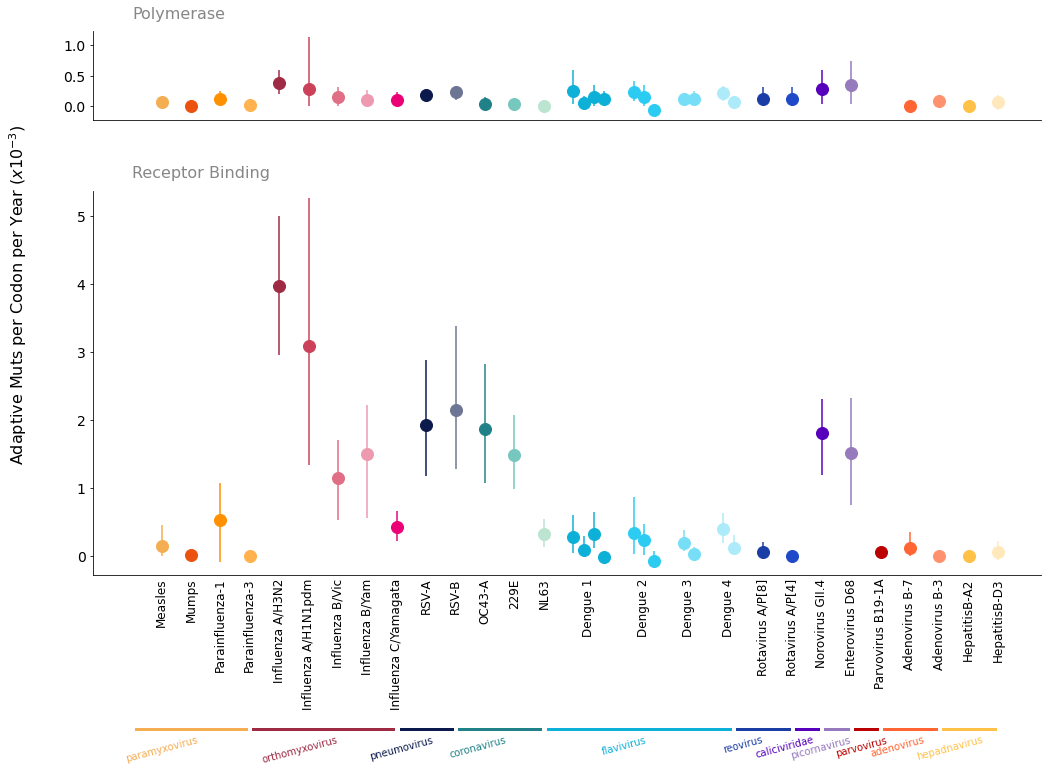

In [62]:
compare_viruses_adaptive_rate(['measles', 'mumps', 'parainfluenza', 'h3n2', 'h1n1pdm', 'vic', 'yam', 'influenzaC', 
                               'rsv', 'oc43', '229e', 'nl63', 'dengue', 
                               'rotavirusAg1p8', 'rotavirusAg1p4', 'norovirus', 'enterovirusd68', 
                               'parvovirusB19', 'adenovirusB7', 'adenovirusB3', 'hepatitisB'], 
                              exclude= ['oc43_b', 'dengue_denv2_AM', 'dengue_denv3_I', 'influenzaC_Mississippi'], 
                              standard_genes=['polymerase','receptor_binding'],
                              bootstrap=True)

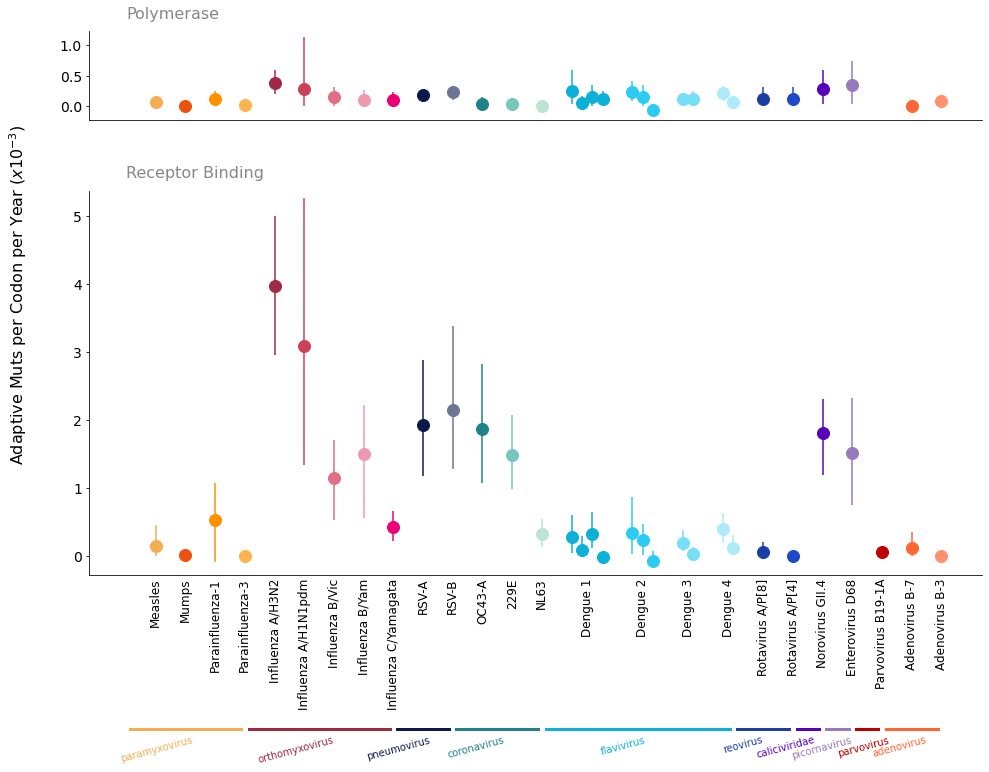

In [114]:
compare_viruses_adaptive_rate(['measles', 'mumps', 'parainfluenza', 'h3n2', 'h1n1pdm', 'vic', 'yam', 'influenzaC', 
                               'rsv', 'oc43', '229e', 'nl63', 'dengue', 
                               'rotavirusAg1p8', 'rotavirusAg1p4', 'norovirus', 'enterovirusd68', 
                               'parvovirusB19', 'adenovirusB7', 'adenovirusB3'], 
                              exclude= ['oc43_b', 'dengue_denv2_AM', 'dengue_denv3_I', 'influenzaC_Mississippi'], 
                              standard_genes=['polymerase','receptor_binding'],
                              bootstrap=True)

In [68]:
def get_rate_in_muts_per_year(virus, subtype, gene, window, min_seqs, year_max, year_min):
    """
    Add a column giving the rate of adaptation (and 95ci, if bootstrapped) in 
    adaptive muts per year (rather than per codon per year)
    """
    
    (virus_time_subset, alignment_time_subset, 
     outgroup_seq, outgroup_seq_aa, 
     year_windows, seqs_in_window) = subset_viruses_nextstrain_build(virus, subtype, gene, window, 
                                                                     min_seqs, year_max, year_min)
    
    gene_len_in_codons = len(outgroup_seq_aa)


    
    return gene_len_in_codons

In [70]:
def save_df_for_altair(viruses, filename, standard_genes=['polymerase', 'membrane_fusion', 'receptor_binding'], 
                       exclude=None,window=3, min_seqs=2, bootstrap=False, 
                       midfreq_high=0.75, midfreq_low=0.15, year_max=None, year_min=None):
    

    
    data_to_plot = []
    color_map = {}
    virus_families = {}
    
    virus_names_legible = {}
    gene_lens_in_codons = {}
    
    for virus in viruses:
        
        configs = readin_virus_config(virus)
        genes = [standardize_gene_name_reverse(virus, x) for x in standard_genes]
        
        if configs['subtype']=='True':
            subtypes = configs['subtypes']
            for subtype in subtypes:
                virus_and_sub = virus+'_'+subtype
                if virus_and_sub not in exclude:
                    gene_lens_in_codons[virus_and_sub] = {}
                    color_map[virus_and_sub] = configs['color'][subtype]
                    virus_families[virus_and_sub] = configs['virus_family']
                    virus_names_legible[virus_and_sub] = configs['legible_name'][subtype]

                    for gene in genes:
                        if gene!="None":
                            gene_len_in_codons = get_rate_in_muts_per_year(virus, subtype, gene, window, min_seqs, year_max, year_min)
                            gene_lens_in_codons[virus_and_sub][standardize_gene_name(virus, gene)] = gene_len_in_codons
                            data_to_plot+=get_data_to_plot(virus, subtype, gene, bootstrap, window, 
                                                                 min_seqs, midfreq_high, midfreq_low, year_max, year_min)

        else:
            subtype=None
            if virus not in exclude:
                gene_lens_in_codons[virus] = {}
                color_map[virus] = configs['color']
                virus_families[virus] = configs['virus_family']
                virus_names_legible[virus] = configs['legible_name']
                for gene in genes:
                    if gene!="None":
                        gene_len_in_codons = get_rate_in_muts_per_year(virus, subtype, gene, window, min_seqs, year_max, year_min)
                        gene_lens_in_codons[virus][standardize_gene_name(virus, gene)] = gene_len_in_codons
                        data_to_plot+=get_data_to_plot(virus, subtype, gene, bootstrap, window, 
                                                             min_seqs, midfreq_high, midfreq_low, year_max, year_min)
    df_to_plot = pd.DataFrame(data_to_plot)
    df_to_plot['len_in_codons'] = df_to_plot.apply(lambda x: gene_lens_in_codons[x['virus_and_subtype']][x['gene']], axis=1)
    #translate into adaptive muts per year (total in gene, rather than rate per codon)
    #adaptive_subs_per_codon_per_year are x10^-3, so divide these numbers by 1000
    df_to_plot['adaptive_muts_per_year'] = (df_to_plot['adaptive_subs_per_codon_per_year']*df_to_plot['len_in_codons'])/1000
    df_to_plot['lower_95ci_mutspergene'] = (df_to_plot['lower_95ci']*df_to_plot['len_in_codons'])/1000
    df_to_plot['upper_95ci_mutspergene']= (df_to_plot['upper_95ci']*df_to_plot['len_in_codons'])/1000
    
    df_to_plot['legible_name'] = df_to_plot['virus_and_subtype'].map(virus_names_legible)
    df_to_plot['virus_family'] = df_to_plot['virus_and_subtype'].map(virus_families)
    df_to_plot['color'] = df_to_plot['virus_and_subtype'].map(color_map)
    if exclude!=None:
        for e in exclude:
            df_to_plot = df_to_plot[df_to_plot['virus_and_subtype']!=e]
            virus_families = {k:v for k,v in virus_families.items() if k not in exclude}
    
    viruses_and_subtypes = list(df_to_plot['virus_and_subtype'].unique())
    
    
    df_to_plot.to_csv(filename, index=False)

 


In [80]:
save_df_for_altair(['measles', 'mumps', 'parainfluenza', 'h3n2', 'h1n1pdm', 'vic', 'yam', 'influenzaC', 
                    'oc43', '229e', 'nl63','rsv', 'hepatitisC', 'lassa', 'dengue', 'rotavirusAg1p8', 
                    'rotavirusAg1p4', 'enterovirusd68', 'norovirus', 'parvovirusB19', 
                    'adenovirusB7', 'adenovirusB3', 'hepatitisB'], 
                   'bhatt_results_nextstrain/concatenated_results_df/results_for_altair.csv', 
                   exclude= ['oc43_b', 'dengue_denv2_AM', 'dengue_denv3_I'], bootstrap=True)

/Users/katekistler/opt/miniconda3/envs/nextstrain/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [43]:
def get_all_time_points(virus, subtype, gene, bootstrap, window, min_seqs, midfreq_high, midfreq_low, year_max, year_min):
    
    all_timepoints = []
    
    if subtype==None:
        virus_subtype = virus
        virus_and_subtype = virus
    else:
        virus_subtype = subtype
        virus_and_subtype = virus+'_'+subtype
    
    if bootstrap:
        save_json_name = 'bhatt_results_nextstrain/'+str(virus_and_subtype)+'_'+str(gene)+'_bhatt_analysis_bootstrapped.json'
        if path.exists(save_json_name):
            with open(save_json_name) as json_handle:
                json_dict = json.load(json_handle)
                (window_midpoint, adaptive_substitutions, 
                 adaptive_substitutions_per_codon, 
                 rate_of_adaptation, bootstrap_adaptive_substitutions, 
                 bootstrap_adaptive_substitutions_per_codon, 
                 bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                                  json_dict['adaptive_substitutions'], 
                                                  json_dict['adaptive_substitutions_per_codon'], 
                                                  json_dict['rate_of_adaptation'], 
                                                  json_dict['bootstrap_adaptive_substitutions'], 
                                                  json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                                  json_dict['bootstrap_rate_of_adaptation'])

        else:

            (window_midpoint, adaptive_substitutions, 
             adaptive_substitutions_per_codon, 
             rate_of_adaptation, bootstrap_adaptive_substitutions, 
             bootstrap_adaptive_substitutions_per_codon, 
             bootstrap_rate_of_adaptation) = calc_bhatt_a(virus, subtype, gene, window, 
                                                          min_seqs, midfreq_high, 
                                                          midfreq_low, bootstrap, year_max, year_min)

            save_json = {'virus': virus, 'subtype':subtype, 'gene': gene, 'window':window, 'min_seqs': min_seqs, 
                         'midfreq_high': midfreq_high, 'midfreq_low': midfreq_low,
                         'window_midpoint':window_midpoint, 'adaptive_substitutions':adaptive_substitutions, 
                         'adaptive_substitutions_per_codon':adaptive_substitutions_per_codon, 'rate_of_adaptation': rate_of_adaptation,
                         'bootstrap_adaptive_substitutions': bootstrap_adaptive_substitutions, 
                         'bootstrap_adaptive_substitutions_per_codon': bootstrap_adaptive_substitutions_per_codon, 
                         'bootstrap_rate_of_adaptation':bootstrap_rate_of_adaptation}
            with open(save_json_name, 'w') as outfile:
                json.dump(save_json, outfile)
        
        for t in range(len(window_midpoint)):
            for x in bootstrap_adaptive_substitutions_per_codon:
                all_timepoints.append({'virus': virus, 'subtype': subtype, 'virus_and_subtype': virus_and_subtype, 
                                       'gene': standardize_gene_name(virus, gene), 
                                       'timepoint': window_midpoint[t],
                                       'adaptive_subs_per_codon': adaptive_substitutions_per_codon[t], 
                                       'bootstrap_adaptive_subs_per_codon': x[t], 
                                       'rate_of_adaptation': rate_of_adaptation})




    else:
        save_json_name = 'bhatt_results_nextstrain/'+str(virus_and_subtype)+'_'+str(gene)+'_bhatt_analysis.json'
        if path.exists(save_json_name):
            with open(save_json_name) as json_handle:
                json_dict = json.load(json_handle)
                (window_midpoint, adaptive_substitutions, 
                 adaptive_substitutions_per_codon, 
                 rate_of_adaptation) = (json_dict['window_midpoint'], 
                                        json_dict['adaptive_substitutions'], 
                                        json_dict['adaptive_substitutions_per_codon'], 
                                        json_dict['rate_of_adaptation'])


        else:
            (window_midpoint, adaptive_substitutions, 
             adaptive_substitutions_per_codon, 
             rate_of_adaptation) = calc_bhatt_a(virus, subtype, gene, window, min_seqs, 
                                                midfreq_high, midfreq_low, 
                                                bootstrap, year_max, year_min)
            

            save_json = {'virus': virus, 'subtype':subtype, 'gene': gene, 'window':window, 'min_seqs': min_seqs, 
                         'midfreq_high': midfreq_high, 'midfreq_low': midfreq_low,
                         'window_midpoint':window_midpoint, 'adaptive_substitutions':adaptive_substitutions, 
                         'adaptive_substitutions_per_codon':adaptive_substitutions_per_codon, 
                         'rate_of_adaptation': rate_of_adaptation}
            with open(save_json_name, 'w') as outfile:
                json.dump(save_json, outfile)
                
        for t in range(len(window_midpoint)):
            all_timepoints.append({'virus': virus, 'subtype': subtype, 'virus_and_subtype': virus_and_subtype, 
                                   'gene': standardize_gene_name(virus, gene), 
                                   'timepoint': window_midpoint[t],
                                   'adaptive_subs_per_codon': adaptive_substitutions_per_codon[t], 
                                   'rate_of_adaptation': rate_of_adaptation})
    

    return all_timepoints


In [60]:
#calculated as slope of adaptive subs per codon
def plot_virus_over_time(viruses, standard_genes=['polymerase', 'receptor_binding', 'membrane_fusion'], 
                                  window=3, min_seqs=2, bootstrap=False, 
                                  midfreq_high=0.75, midfreq_low=0.15, year_max=None, year_min=None, filename=None):
    

    
    data_to_plot = []
    color_map = {}
    virus_families = {}
    
    for virus in viruses:
        
        configs = readin_virus_config(virus)
        genes = [standardize_gene_name_reverse(virus, x) for x in standard_genes]
        
        if configs['subtype']=='True':
            subtypes = configs['subtypes']
            for subtype in subtypes:
                virus_and_sub = virus+'_'+subtype
                color_map[virus_and_sub] = configs['color'][subtype]
                virus_families[virus_and_sub] = configs['virus_family']
                for gene in genes:
                    if gene!="None":
                        data_to_plot+=get_all_time_points(virus, subtype, gene, bootstrap, window, 
                                                             min_seqs, midfreq_high, midfreq_low, year_max, year_min)

        else:
            subtype=None
            color_map[virus] = configs['color']
            virus_families[virus] = configs['virus_family']
            for gene in genes:
                if gene!="None":
                    data_to_plot+=get_all_time_points(virus, subtype, gene, bootstrap, window, 
                                                         min_seqs, midfreq_high, midfreq_low, year_max, year_min)


    df_to_plot = pd.DataFrame(data_to_plot)
    
    legible_titles_genes = {'polymerase': 'Polymerase', 'receptor_binding': 'Receptor Binding', 
                      'membrane_fusion': 'Membrane Fusion'}
    df_to_plot['gene_title'] = df_to_plot['gene'].map(legible_titles_genes)
    
    legible_titles_viruses = {'rsv_A': 'RSV-A', 'rsv_B': 'RSV-B', 
                             '229e': '229E', 'oc43_a': 'OC43-A', 
                             'oc43_b': 'OC43-B', 'nl63': 'NL63', 
                              'measles': 'Measles', 'h3n2': 'H3N2', 
                              'enterovirusd68': 'Enterovirus D68', 'norovirus': 'Norovirus GII.4', 
                              'hepatitisB_A2':'hepatitisB-A2', 
                              'hepatitisB_C':'hepatitisB-C','hepatitisB_D3':'hepatitisB-D3'}
    df_to_plot['virus_title'] = df_to_plot['virus_and_subtype'].map(legible_titles_viruses)

    df_to_plot = df_to_plot[df_to_plot['virus_title'].isin(['Measles', 'H3N2', 'OC43-A', 'RSV-B', 'NL63', '229E', 'Enterovirus D68', 'Norovirus GII.4', 'hepatitisB-A2', 'hepatitisB-C', 'hepatitisB-D3'])]
    
    g = sns.FacetGrid(df_to_plot, row='virus_title', col='gene_title', 
                       hue='virus_and_subtype', palette=color_map, 
                      margin_titles=True, sharex=True)
    
    g.map_dataframe(sns.regplot, x="timepoint", y="adaptive_subs_per_codon")
    
    g.set_titles(col_template="{col_name}", row_template="{row_name}", size=14)
    
    g.set_axis_labels("Date", "Adaptive Subs per Codon", size=12)
    
    g.tight_layout()
    
    if filename:
        g.savefig(filename, dpi=300, bbox_inches='tight')
    




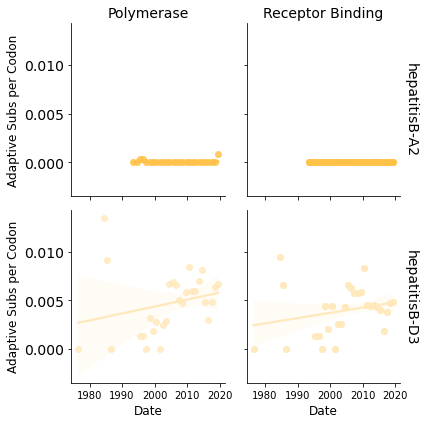

In [63]:
plot_virus_over_time(['hepatitisB'], bootstrap=False)

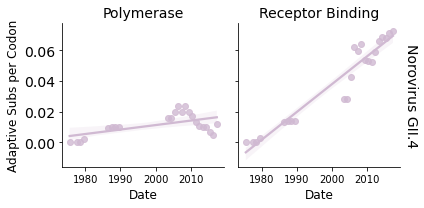

In [134]:
plot_virus_over_time(['norovirus'], bootstrap=False, filename='plots/norovirus_adaptation_accumulation.png')

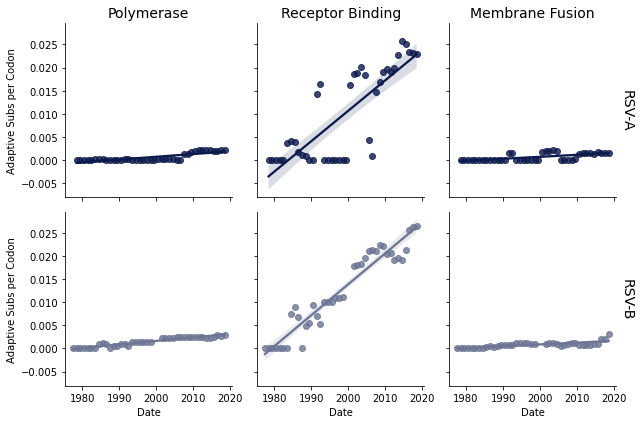

In [102]:
plot_virus_over_time(['rsv'], bootstrap=False)

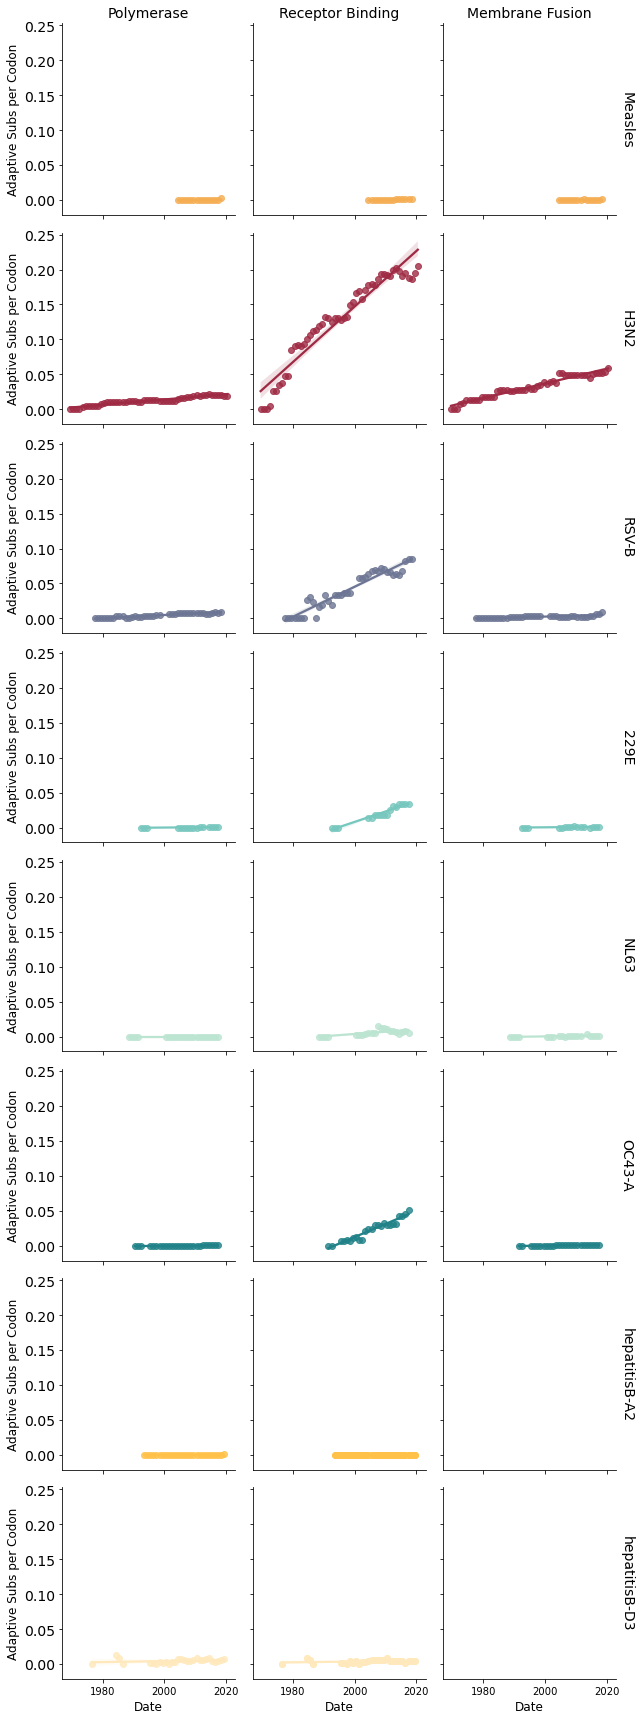

In [66]:
plot_virus_over_time(['measles', 'h3n2', 'rsv', '229e', 'nl63', 'oc43', 'hepatitisB'], bootstrap=False)